<h1><center> IZBACIVANJE ZNAČAJKI NA TEMELJU TOČNOSTI MODELA </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

In [1]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.utils import class_weight

from functions.model_helper import *
from functions.fs_helper import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


C:\Users\Matea\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# remember default python style
#IPython_default = plt.rcParams.copy()

In [3]:
# dictionary for saving malware names
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

# define seed
seed = 42

<br><br>

In [4]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)

# malware ids
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")

# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

# features with filled NaN with zero
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

In [5]:
features_train_with_filled_NaN_without_id.head()

,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,byte_1G_08,byte_1G_09,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,21091,1213,726,817,1257,625,550,523,1078,473,...,0,0,0,0,0,0,0,0,0,0
1,40030,1980,1226,1193,1971,1096,961,755,2406,550,...,0,0,0,0,0,0,0,0,0,0
2,19419,955,693,656,832,463,370,510,836,449,...,0,0,0,0,0,0,0,0,0,0
3,79568,6445,3143,2517,4982,1824,2125,2964,8301,1530,...,0,0,2,0,0,0,0,0,0,0
4,25791,1202,569,750,948,456,405,517,754,494,...,0,0,0,0,0,0,0,0,0,0


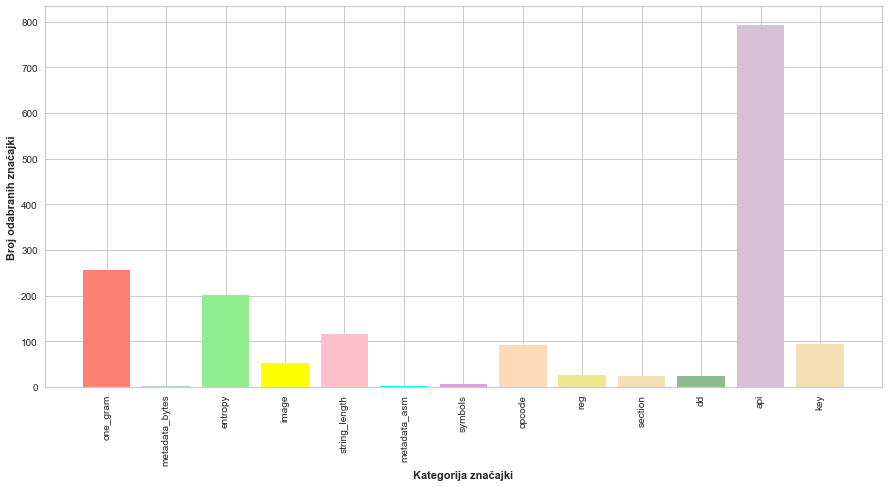

In [6]:
features_type_quantity(features_train_with_filled_NaN_without_id, features_train)

<br>

## unigrami

In [7]:
# extract
one_gram_features = features_train_with_filled_NaN_without_id.iloc[:,:256]
one_gram_features_test = features_test_with_filled_NaN_without_id.iloc[:,:256]

Kao što smo napomenuli u [Feature extraction](https://github.com/tomarga/Machine-Burning/blob/master/src/Feature%20extraction.ipynb) bilježnici, ove značajke odabrane su iz razloga što opisuju <b> strukturu programa</b>. Detaljnije o tome možemo vidjeti u članku [What Can N-Grams Learn for Malware Detection?](https://www.edwardraff.com/publications/what_can_ngrams_learn.pdf). 

<br><br>

Sada ćemo napraviti jednostavni model za klasifikaciju <i>malware</i>-a korišteći samo ove značajke te pomoću raznih metrika točnosti pokušati predvidjeti njihovu značajnost u konačnom modelu.

In [8]:
data = one_gram_features
data_test = one_gram_features_test
labels = malware_classes_train.values.ravel()

In [9]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [10]:
# xgboost with default parameters
basic_model_xgb = XGBClassifier_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)

Load or make XGBClassifier? load
Izaberi XGBClassifier:
1. basic_model_xgb
2. basic_one_gram
4. basic_entropy
5. basic_image
6. basic_string_len
7. basic_metadata_asm
8. basic_symbols
9. basic_opcode
10. basic_reg
11. basic_section
12. basic_dd
13. basic_api
14. basic_keywords
15. all_features
2


In [11]:
model = basic_model_xgb

In [12]:
# load ~> trebam napraviti da se može loadati iz funkcije isti
# model = basic_model_xgb = pickle.load(open('data/model_xgb_one_gram.sav', 'rb'))

In [13]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.049518
1,accuracy_test,0.987121
2,F1_test,0.987104
3,precision_test,0.987335
4,auc_test_ovr,0.999675
5,auc_test_ovo,0.999521
6,r2_test,0.947490


Ovdje smo ispisali različite metrike uspješnosti našega jednostavnog modela. Ono što možemo primjetiti da su rezultati svih metrika vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

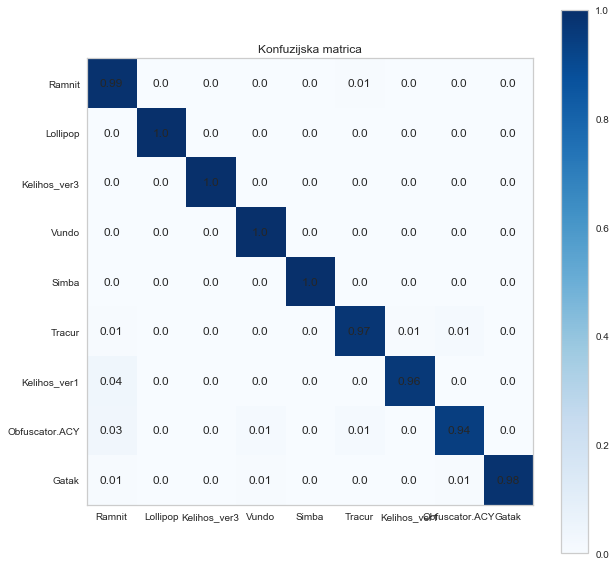

In [14]:
# plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

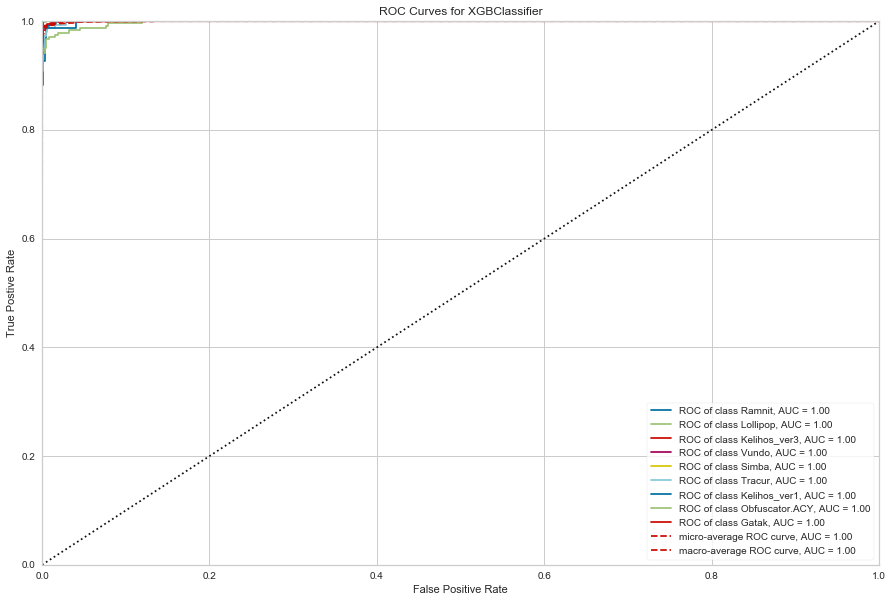

In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#plt.style.use(plt.style.available[20])
#plt.rcParams.update(IPython_default);

rocauc = ROCAUC(model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict )

rocauc.score(X_test, y_test)    
r = rocauc.poof()

Na gornjoj slici možemo vidjeti uspješnost modela prikazanu preko <i>ROC</i> krivulje. Za sve klase, površina ispod te krivulje (<i>AUC</i>) je maksimalna, odnosno iznosi $1$, što je još jedan pokzatelj dobroga modela.

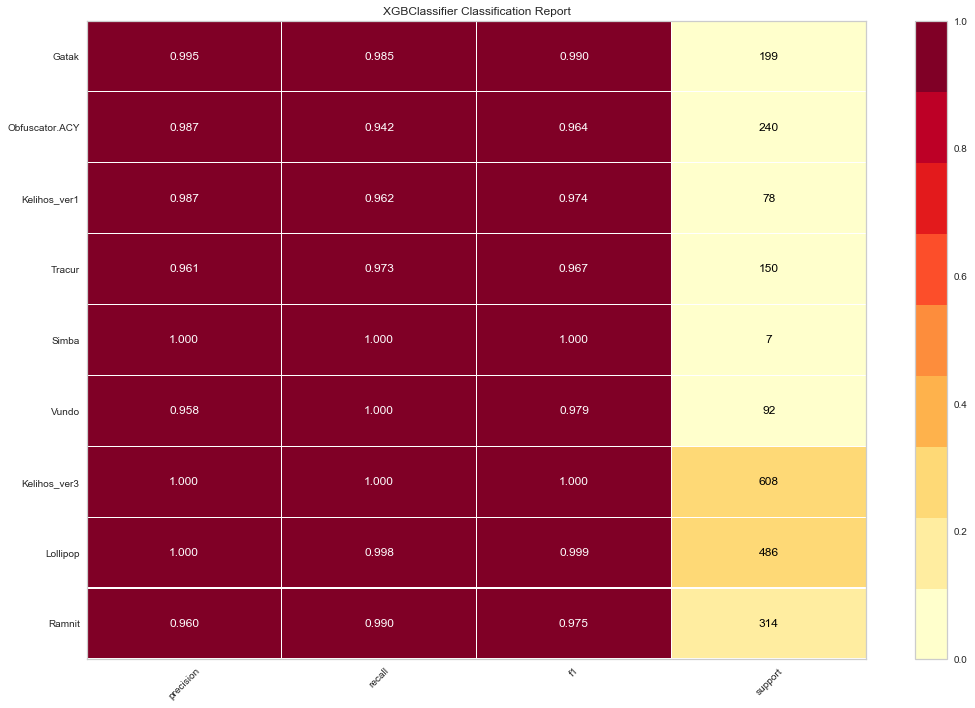

In [16]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Vidimo da korišteći samo unigram značajke, najosnovniji model se dobro nosi i sa <i>precision</i> i sa <i>recall</i> i sa <i>f1</i> točnosti svake od klasa. 

<span style="color:orange"><i>
Iako je <code>XGBoost</code> otporniji na <i>overfitting</i> nego ostale metode klasifikacije, promatrajući rezultate mogli bismo zaključiti da je došlo do <i>overfitting</i>-a. To ćemo provjeriti <i>submit</i>-anjema na <i>Kaggle</i>-e naših pretpostavki na $10873$ <i>malware</i>-a za koje nam nije poznata klasa u koju pripadaju.
</i></span>

<span style="color:red">
Ne baš napisati ovako da se koristi riječ overfitting jer ovo je točnost na nepoznatim podacima, odnosno <b>kao</b> "testu", ali napisati nešto u tom smislu. Kao u slučaju (što je slučaj) da su pravi test podaci možda drugačije građe. A ne očekuje se overfiting na onegram featurima jer postoje razne studije koje govore kak su onegram stvarno bitni. Npr onaj gore referenciran.
</span>

Broj malwarea po klasama:
dict_values([1564, 2470, 2945, 479, 40, 763, 395, 1215, 1002])
Postotci malware-aa po klasama:
[14.384254575554126, 22.716821484410925, 27.085441000643794, 4.40540789110641, 0.3678837487353996, 7.017382507127748, 3.632852018762071, 11.174468867837763, 9.21548790582176]


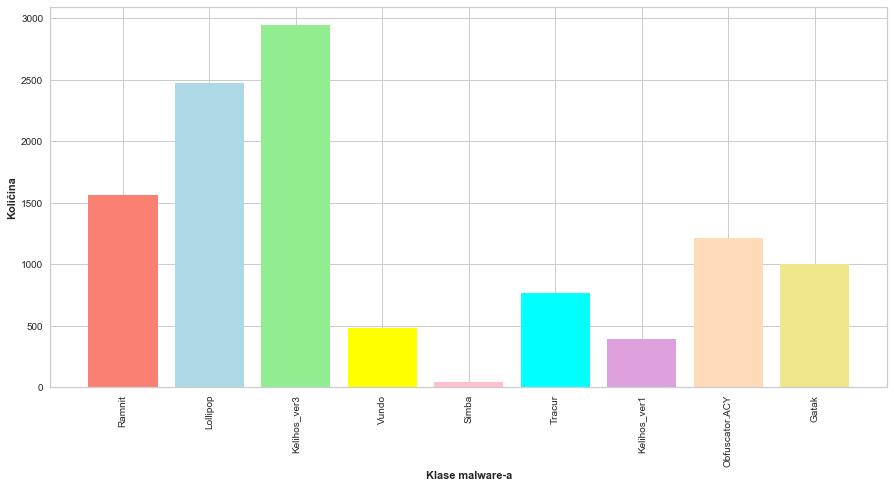

In [17]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Prije <i>submit</i>-anja, mogli bismo nešto reći o našim rezultatima na $10873$ <i>malware</i>-a za koje nam nije poznata klasa iz prethodno nacrtanog grafa. Naime, on pokazuje raspodjelu tih podataka po klasama. Ako se prisjetimo kako je izgledao isti graf na podacima za koje nam je bila poznata klasa <i>malware</i>-a u koju pripadaju ([Projektni prijedlog](https://github.com/tomarga/Machine-Burning/blob/master/src/%5Bproject%20proposal%5D%20microsoft%20malware%20classification.ipynb)), mogli bismo, samo iz ta dva grafa, reći da smo dobro grupirali podatke jer je distribuiranost po klasama vrlo slična i u jednom i u drugom grafu.

In [ ]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Uistinu, model se pokazao izvrstan i na nepoznatim podacima.

<span style="color:red">
Ovdje se možda osvrnuti na project proposal biljeznicu di smo stvarno predvidili da ce ovi featuri bit bitni. Ima i zavrceno na logistickoj regresiji. Nesto od tog iskoristiti. Tj bitno da se malo osvrenemo na tu bilju.
</span>

<code> kaggle score: 0.05030 </code>

<br>

## (byte) metadata

<br><br><br>


***